# Encoder-Decoder Transformer architecture 

From `attention is all you need`: https://arxiv.org/pdf/1706.03762, it is not 1to1 replication but a similar thing with only one block.

### Data set

toy data set to generate infinite samples

In [1]:
from simple_expressions import SimpleExpression, expr_vocabulary, PADDING_TOKEN_ID, encode_expression, decode_expression
import torch as th

def left_pad(
    sequences: list[list[int]],
    pad_id: int
) -> th.Tensor:

    max_len = max(len(seq) for seq in sequences)
    padded = [
        [pad_id] * (max_len - len(seq)) + seq
        for seq in sequences
    ]
    return th.tensor(padded, dtype=th.long)
    
def right_pad(
    sequences: list[list[int]],
    pad_id: int
) -> th.Tensor:
    max_len = max(len(seq) for seq in sequences)
    padded = [
        seq + [pad_id] * (max_len - len(seq))
        for seq in sequences
    ]
    return th.tensor(padded, dtype=th.long)
    
def prepare_batch(
    expressions: list[str],
    answers: list[str],
) -> tuple[th.Tensor, th.Tensor, th.Tensor]:
    enc_seqs = [encode_expression(expr) for expr in expressions]
    ans_seqs = [encode_expression(ans) for ans in answers]

    encoder_input = left_pad(enc_seqs, PADDING_TOKEN_ID)
    # everything except the End of answer ']'
    decoder_input = right_pad([ans[:-1] for ans in ans_seqs], PADDING_TOKEN_ID)
    # everything except the begining of answer '['
    decoder_target = right_pad([ans[1:] for ans in ans_seqs], PADDING_TOKEN_ID)

    return encoder_input, decoder_input, decoder_target


sampler = SimpleExpression(3, (1, 3), (-10, 10), 2, 0.5)
expressions, answers = sampler.sample(3)
encoder_input, decoder_input, decoder_target = prepare_batch(
    expressions,
    answers,

)
for i in range(3):
    print("Source:")
    print(expressions[i], answers[i])
    print("Decoded:")
    print(''.join(decode_expression(encoder_input[i])), ''.join(decode_expression(decoder_input[i])), 'X' , ''.join(decode_expression(decoder_target[i]))) 
    print()

Source:
$( i * ( k ) + a );i=-1.02,a=3.13,k=-4.9! [8.13]
Decoded:
|$( i * ( k ) + a );i=-1.02,a=3.13,k=-4.9! [8.13| X 8.13]|

Source:
$s + ( z ) + r;s=6.85,z=-9.3,r=-0.54! [-2.99]
Decoded:
|||||$s + ( z ) + r;s=6.85,z=-9.3,r=-0.54! [-2.99 X -2.99]

Source:
$( c + ( u ) * a );a=-1.75,c=8.11,u=-7.37! [21.01]
Decoded:
$( c + ( u ) * a );a=-1.75,c=8.11,u=-7.37! [21.01 X 21.01]



## Masked MHA, Encoder & Decoder

Decoder has Cross attention layer using masked attention output as queries and encoder output as key and values

In [2]:
class MultiHeadAttention(th.nn.Module):
    def __init__(self, in_dim: int, out_dim: int, heads: int, masked: bool):
        assert in_dim % heads == 0, f"Uneven outdim and heads {in_dim} % {heads} != 0"
        super().__init__()

        self.num_heads = heads
        self.head_dim = in_dim // heads
        self._sf_scalar = self.head_dim ** 0.5
        self._is_masked = masked

        # Using same matrix for all heads
        # But needed different QKV parameters since same x will not be used
        self.Q = th.nn.Linear(in_dim, in_dim)
        self.K = th.nn.Linear(in_dim, in_dim)
        self.V = th.nn.Linear(in_dim, in_dim)
        
        
        self.lnorm = th.nn.LayerNorm(in_dim)
        self.feed_forward = th.nn.Linear(in_features=in_dim, out_features=out_dim)

    def forward(self, q: th.Tensor, k: th.Tensor, v: th.Tensor, resid: th.Tensor | None, pad_mask: th.Tensor,):
        if resid is None:
            resid = v 
        B, T_d, _ = q.shape # In cross attention, query will have different sequence
        _, T, _ = k.shape
        # (heads, B, T, h_dim)
        qu = self.Q(q).view(self.num_heads, B, T_d, self.head_dim)
        ke = self.K(k).view(self.num_heads, B, T, self.head_dim)
        va = self.V(v).view(self.num_heads, B, T, self.head_dim)

        # [heads, B, T_d, T]
        scores = qu @ ke.mT 
        block_mask = pad_mask.unsqueeze(-1)
        
        if self._is_masked:
            # block queries attending to future keys 
            attn_mask = th.tril(th.ones(T,T)) == 0
            block_mask = block_mask | attn_mask
           
        scores = scores.masked_fill( block_mask,  float('-inf'))
        scores = th.nan_to_num(scores) # if all entries in vectors are padded, make em 0
        # using scalled dot product attention 
        alpha = th.softmax(scores/ self._sf_scalar, dim=-1)

        # [heads, B, T_d, h_dim]
        attention = alpha @ va
        # the padding has to be (1, B, T_d, 1)
        attention = attention * (~pad_mask[None, ..., None]) # zeroing out padding tokens

        # [B, T_d, heads, h_dim]
        attention = attention.permute(1, 2, 0, 3)
        # [B, T_d, D], to combine heads *h_dim, we needed to lay them in memory in order heads, h_dim 
        # then only when combining them to single dimension it will properly concatenate the data
        attention = attention.contiguous().view(B, T_d, -1)

        
        # Residual connection and layer norm
        resid_norm = self.lnorm(attention + resid)
        
        # final feedforward and non linearity
        logits = self.feed_forward(resid_norm) * (~pad_mask[...,None])
        return th.relu(logits)
        
with th.no_grad():
    batch = 10
    contxt_window = 32
    embedding_size = 8
    out_dim = 3
    mattn = MultiHeadAttention(in_dim=embedding_size, out_dim=out_dim,heads=2,masked=True)
    # setting right half as valid tokens and left as paddings
    pad_mask = th.zeros(batch, contxt_window)
    pad_mask[:, contxt_window//2:] = 1 
    pad_mask = (pad_mask==0)
    
    x = th.randn(batch, contxt_window, embedding_size)
    # make the left side 0 embedding vectors
    x[:, :contxt_window//2, :] = 0 
    
    out = mattn(x,x,x,None,pad_mask)
    assert out.shape == (batch, contxt_window, out_dim)
        # left half full of zeros, right half full of values
    assert out[:,:16,:].sum() == 0
    assert abs(out[:,16:,:].sum()) >= 0

In [3]:
from torch import nn
class Encoder(nn.Module):
    def __init__(self, vocab_size: int,  embedding_dim: int, output_dim: int, padding_idx: int, ctxt_size: int, heads:int):
        super().__init__()
        self._padding_id = padding_idx
        # # initialize embeddings as on hot encoded vector + small noise
        # noisy_onehot = th.eye(vocab_size) + (th.randn(vocab_size, vocab_size) - 0.5) * 0.033
        self.embeddings = th.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim,padding_idx=padding_idx) #.from_pretrained(noisy_onehot, padding_idx=padding_idx)
        self.pos_embd = th.nn.Embedding(num_embeddings=ctxt_size+1, embedding_dim=embedding_dim, padding_idx=0)

        self.attn = MultiHeadAttention(embedding_dim, output_dim, heads,masked=False)

    def forward(self, x: th.Tensor):
        x_embd = self.embeddings(x) # {B, seq, n]
        pad_mask = (x == self._padding_id)

         # [0,0,0,0,1,2,3,4..]
        token_positions = (~pad_mask).cumsum(dim=1)
        pos_embd = self.pos_embd(token_positions)

        x_embd += pos_embd
        return self.attn(x_embd,x_embd,x_embd,None,pad_mask)

class Decoder(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, padding_idx: int, ctxt_size: int, heads:int):
        super().__init__()
        self._padding_id = padding_idx
        # # initialize embeddings as on hot encoded vector + small noise
        # noisy_onehot = th.eye(vocab_size) + (th.randn(vocab_size, vocab_size) - 0.5) * 0.033
        self.embeddings = th.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim,padding_idx=padding_idx) #.from_pretrained(noisy_onehot, padding_idx=padding_idx)
        self.pos_embd = th.nn.Embedding(num_embeddings=ctxt_size+1, embedding_dim=embedding_dim, padding_idx=0)

        self.masked_attn = MultiHeadAttention(embedding_dim, hidden_dim, heads,masked=True)
        self.cross_attn = MultiHeadAttention(hidden_dim, hidden_dim, heads,masked=False)

        self.ff = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x: th.Tensor, encodings: th.Tensor):
        x_embd = self.embeddings(x) # {B, seq, n]
        pad_mask = (x == self._padding_id)

         # [0,0,0,0,1,2,3,4..]
        token_positions = (~pad_mask).cumsum(dim=1)
        pos_embd = self.pos_embd(token_positions)

        x_embd += pos_embd
        masked_attn = self.masked_attn(x_embd,x_embd,x_embd,None, pad_mask)
        # in cross attention, we will be using the decoder attention as query to attend encodings
        attention = self.cross_attn(q=masked_attn, k=encodings, v=encodings, resid=masked_attn, pad_mask=pad_mask)

        return th.relu(attention)

class Transformer(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, padding_idx: int, ctxt_size: tuple, heads:int):
        super().__init__()
        self.encoder = Encoder(vocab_size, embedding_dim, hidden_dim, padding_idx, ctxt_size, heads) 
        self.decoder = Decoder(vocab_size, embedding_dim, hidden_dim, padding_idx, ctxt_size, heads)
        self.feed_forward = th.nn.Linear(hidden_dim, vocab_size)

    def forward(self, expr: th.Tensor, result: th.Tensor):
        encodings = self.encoder(expr)
        decodings = self.decoder(result, encodings)
        return self.feed_forward(decodings)
        

with th.no_grad():
    model = Transformer(vocab_size=10, embedding_dim=12,hidden_dim=12, padding_idx=0,ctxt_size=32, heads=4)
    x = th.randint(0, 10, (8, 32))
    r = th.randint(0, 10, (8, 32))
    logits = model(x,r)
    # we need (batch, seq len, prob of vocab) 
    # that means next prediction for each token in the sequence
    assert logits.shape == (8, 32, 10)

## Training Loop

In [4]:
embedding_dim = 64
hidden_dim = 128
context_window = 512
heads = 4

calc = Transformer(vocab_size=len(expr_vocabulary), embedding_dim=embedding_dim,hidden_dim=hidden_dim, padding_idx=PADDING_TOKEN_ID,ctxt_size=context_window, heads=heads)

# Total parameters
total_params = sum(p.numel() for p in calc.parameters())

# Trainable parameters only
trainable_params = sum(p.numel() for p in calc.parameters() if p.requires_grad)

print(f"Total: {total_params:,}")
print(f"Trainable: {trainable_params:,}")

param_size = 0
for param in calc.parameters():
    param_size += param.nelement() * param.element_size()
    
buffer_size = 0
for buffer in calc.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print(f"Model size: {size_all_mb:.3f} MB")

Total: 194,668
Trainable: 194,668
Model size: 0.743 MB


In [5]:
from tqdm.notebook import tqdm

eta = 1e-3
epochs = 10
batch_size = 128
batches_per_epoch = 32

criterion = th.nn.CrossEntropyLoss(ignore_index=PADDING_TOKEN_ID)
optimizer = th.optim.Adam(calc.parameters(), lr=eta)

losses = []

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    batch_bar = tqdm(range(batches_per_epoch),
                     desc=f"Epoch #{epoch+1}",
                     leave=False)

    for _ in batch_bar:
        exprs, answers = sampler.sample(batch_size)
        encoder_input, decoder_input, decoder_target = prepare_batch(
            exprs,
            answers,
        )


        optimizer.zero_grad()

        logits = calc(encoder_input, decoder_input)
        # (B*T_d, vocab_size)
        logits = logits.reshape(-1, logits.size(-1))
        # (B*T_d,)
        decoder_target = decoder_target.reshape(-1)
        
        loss = criterion(logits, decoder_target)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        losses.append(loss_val)
        batch_bar.set_postfix(loss=f"{loss_val:.4f}")

Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch #1:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #2:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #4:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #5:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #6:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #7:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #8:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #9:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch #10:   0%|          | 0/32 [00:00<?, ?it/s]

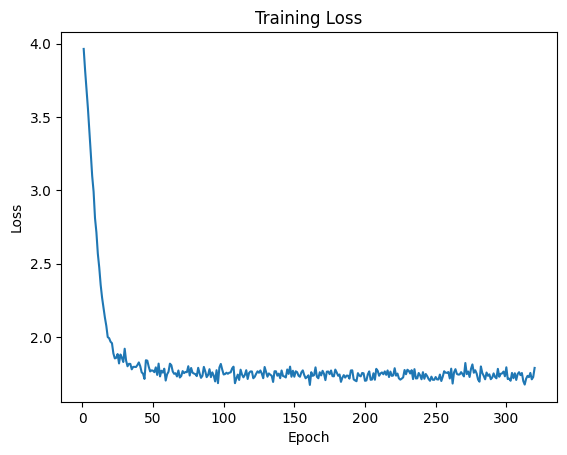

In [6]:
import matplotlib.pyplot as plt 

updates = list(range(1, len(losses)+1))
plt.figure()
plt.plot(updates, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [8]:
def sample(
    calc,
    expr: str,
    max_len: int = 10,
    greedy: bool = True,
):
    expr_len = len(expr)

    expr = [encode_expression(expr)]
    result = [[expr_vocabulary['[']]]

    with th.no_grad():
          
        for _ in range(max_len):
            expt = th.tensor(expr)
            rest = th.tensor(result)
            logits = calc(expt, rest)
            # logits: [1, Seq, vocab]
            # select last token predictions
            logits = logits[:,-1,:]
    
            if greedy:
                next_token = logits.argmax(dim=-1)
            else:
                probs = th.softmax(logits, dim=-1)
                next_token = th.multinomial(probs, num_samples=1).squeeze(1)
    
            result[0].append(next_token.item())
    
            # early stop if all finisheds
            if (next_token == expr_vocabulary[']']).all():
                break
    
    return result[0]

for expr, ans in zip(*sampler.sample(10)):
    result = sample(calc, expr, greedy=False)
    predict = ''.join(decode_expression(result))
    print(f"{expr} = {ans}\nCalc = {predict}")

$( i * ( v + s ) );s=8.38,i=2.84,v=9.88! = [51.86]
Calc = [-4.5]
$y * o * j;j=9.59,o=-9.27,y=3.13! = [-278.25]
Calc = [-3.785]
$r * ( a / o );o=-5.95,a=-4.14,r=-0.28! = [-0.19]
Calc = [3.92]
$( o * ( j + s ) );s=-5.32,o=2.33,j=3.68! = [-3.82]
Calc = [-17.2]
$i / f;i=1.56,f=1.4! = [1.11]
Calc = [26.44]
$f + s + i;s=0.72,i=1.53,f=-8.24! = [-5.99]
Calc = [-2482]
$( e ) / ( s ) + r;e=7.69,s=-3.94,r=-1.1! = [-3.05]
Calc = [132.5]
$w - x - j;j=-9.04,w=3.67,x=-3.0! = [15.71]
Calc = [-11]
$k * v / u;u=2.76,v=-5.42,k=7.93! = [-15.57]
Calc = [-1.9]
$x - ( v + l );l=-2.67,v=-7.04,x=1.84! = [11.55]
Calc = [16854]
